In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import pyiast as iast
import numpy as np
import ternary as tern
import math

In [85]:
gases = ["CH4", 
         "N2", 
         "CO2", 
         "C2H6"
        ]

In [86]:
#df_dict = {"N2" : pd.read_csv("N2_HKUST-1.csv", comment='#'), "CH4" : pd.read_csv("CH4_HKUST-1.csv", comment='#')}
df_dict = dict(zip(gases, [pd.read_csv(gas+"_HKUST-1.csv", comment='#') for gas in gases]))

In [87]:
df_dict["N2"]["p(bar)"] = df_dict["N2"]["p(MPa)"] * 10

In [88]:
"""
unit conversion
cm3/g --> mmol/g

* L/1000cm3 * mol/22.4L * 1000mmol/mol
"""

'\nunit conversion\ncm3/g --> mmol/g\n\n* L/1000cm3 * mol/22.4L * 1000mmol/mol\n'

In [89]:
df_dict["CH4"]["N(mmol/g)"] = df_dict["CH4"]["cm3/g"] / 22.4

In [90]:
hkust1_density = 879 # kg/m^3
"""
cm^3stp/cm^3mof * Lstp/1000cm^3stp * mol/22.4Lstp * 1000mmol/mol * m^3/879kg * kg/1000g * 10^6cm^3mof/m^3

1000/(22.4*879)
"""
df_dict["C2H6"]["N(mmol/g)"] = df_dict["C2H6"]["N(cm3STP_cm3)"] * 1000/22.4/hkust1_density
df_dict["C2H6"]["p(bar)"] = df_dict["C2H6"]["P(mmHg)"] / 750

In [91]:
isotherm_dict = {}
for gas in gases:
    isotherm_dict[gas] = iast.ModelIsotherm(df_dict[gas], loading_key="N(mmol/g)", pressure_key="p(bar)", model="Langmuir")

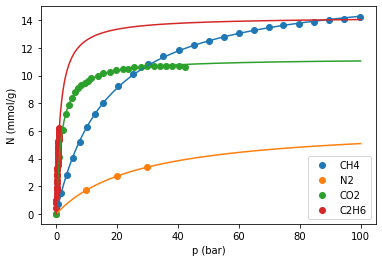

In [92]:
plt.figure()

p_range = np.linspace(0, 100, 500)

for gas in gases:
    plt.scatter(df_dict[gas]["p(bar)"], df_dict[gas]["N(mmol/g)"], marker='o', label=gas)
    plt.plot(p_range, isotherm_dict[gas].loading(p_range))
    
#plt.xlim(0, 1)
plt.xlabel("p (bar)")
plt.ylabel("N (mmol/g)")
plt.legend()

In [94]:
x_ch4 = np.linspace(0, 1)
m_ads = np.zeros(len(x_ch4))
mol_wts = {"N2" : 28., "CH4" : 16., "CO2" : 44.009, "C2H6" : 30.07}

In [95]:
def adsorbed_mass(mol_fxns):
    q = iast.iast(mol_fxns, [isotherm_dict[gas] for gas in gases], warningoff=True)
    # q: mmol/g mof
    # mol_wts: g gas/mol 
    # m_ads: g gas/g mof
    return np.sum([q[j] * mol_wts[gases[j]] for j in range(len(gases))]) / 1000

In [97]:
delta = 0.005
x = np.arange(0.01, 0.3, delta)
y = np.arange(0.01, 0.3, delta)
X, Y = np.meshgrid(x, y)
Z = np.zeros(np.shape(X))
for i in range(np.shape(X)[0]):
    for j in range(np.shape(Y)[1]):
        mol_fxn = [1 - x[i] - y[j], x[i], y[j]]
        Z[j,i] = adsorbed_mass(mol_fxn)

Example use:

              IAST([0.5,0.5], [xe_isotherm, kr_isotherm], verboseflag=true)


Exception: Length of partial pressures != length of array of isotherms...

<ipython-input-98-dee2f9d2f5ff>:2: UserWarning: No contour levels were found within the data range.
  CS = ax.contour(X, Y, Z)


Text(0, 0.5, 'CO2 Fraction')

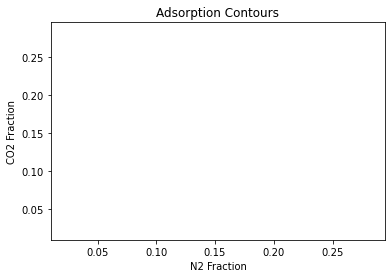

In [98]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Adsorption Contours')
ax.set_xlabel("N2 Fraction")
ax.set_ylabel("CO2 Fraction")

In [111]:
def V(x, y, z):
    x, y, z = x[0][0], y[0][0], z[0][0]
    print(x, y, z)
    if x + y + z <= 1:
        return adsorbed_mass([1 - x - y - z, x, y, z])
    else:
        return NaN

In [112]:
X, Y, Z = np.mgrid[0.001:0.003:0.999, 0.001:0.003:0.999, 0.001:0.003:0.999]
X, Y, Z

(array([[[0.001]]]), array([[[0.001]]]), array([[[0.001]]]))

In [113]:
V(X, Y, Z)

[0.001] [0.001] [0.001]


0.010543416972347654

In [115]:
from mayavi import mlab
mlab.contour3d(X, Y, Z, V)

[0.001] [0.001] [0.001]


AssertionError: argument shape are not equal

In [114]:
figure, tax = tern.figure(scale=100)
tax.heatmapf(adsorbed_mass, boundary=False, style="hexagonal")
tax.gridlines(multiple=10)
tax.ticks(multiple=10)
tax.set_title("Heatmap")
tax.left_axis_label(gases[2])
tax.right_axis_label(gases[1])
tax.bottom_axis_label(gases[0])

AttributeError: module 'ternary' has no attribute 'figure'

In [ ]:
# near-pure CH4
adsorbed_mass([0.99,0.005,0.005])

In [ ]:
# near-pure N2
adsorbed_mass([0.005, 0.99, 0.005])

In [ ]:
# near-pure CO2
adsorbed_mass([0.005,0.005,0.99])

In [ ]:
figure, tax = tern.figure(scale=100)
tax.scatter([[1,0,0]])
tax.ticks(multiple=25)

In [ ]:
plt.figure()
plt.plot(x_ch4, m_ads)
plt.ylim(ymin=0)
plt.xlabel("Fraction of CH4")
plt.ylabel("Total Adsorbed Mass (g/g)")
plt.title("Calibration Curve")